In [1]:
## pycistarget terminal version

import warnings
warnings.simplefilter(action = 'ignore')
import pycisTopic
pycisTopic.__version__
import numpy as np
import pandas as pd

projDir = '~/CH/CH-cross/Fig3/Scenicplus/dr11/'
outDir = projDir + 'output/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)
tmpDir = '~/CH/tmp/'
if not os.path.exists(tmpDir):
    os.makedirs(tmpDir)

In [2]:
## ray init
import ray
ray.init('auto')
#ray.init(address='10.105.100.3:6379')
#assert ray.is_initialized() ==True

2023-04-16 05:03:14,894	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 210.32.148.185:6379...
2023-04-16 05:03:14,945	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.13
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [3]:
#
from scenicplus.scenicplus_class import SCENICPLUS, create_SCENICPLUS_object
from scenicplus.preprocessing.filtering import *

# load data
import pickle
infile = open('~/CH/CH-cross/Fig3/Scenicplus/dr11/output/dr11_cluster_cistopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

import pickle
infile = open('~/CH/CH-cross/Fig3/Scenicplus/dr11/output/DARs/Imputed_accessibility.pkl', 'rb')
imputed_acc_obj = pickle.load(infile)
infile.close()

infile = open('~/CH/CH-cross/Fig3/Scenicplus/dr11/output/pycisTarget/menr.pkl', 'rb') # change here

menr = pickle.load(infile)
infile.close()

In [4]:
## RNA 
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
import scanpy as sc
import numpy as np
rna_anndata = sc.read_loom('~/CH/CH-cross/Fig3/Scenicplus/dr11/dr11_rna_lineage_pseudo_20.loom')
rna_anndata


## Create Scenicplus object.
scplus_obj = create_SCENICPLUS_object(GEX_anndata = rna_anndata, 
                                     cisTopic_obj = cistopic_obj,
                                     imputed_acc_obj = imputed_acc_obj,
                                     menr = menr,
                                     multi_ome_mode = False,
                                     key_to_group_by = 'lineage',
                                     nr_cells_per_metacells = 5)

2023-04-16 05:10:57,515 create scenicplus object INFO     Following annotations were found in both assays under key lineage:
	Neuron, Endothelial, Nephron, Muscle, Epithelial, Gut, Hepatocyte, Immune, Stromal.
Keeping 5691 cells for RNA and 27007 for ATAC.
2023-04-16 05:18:46,274 create scenicplus object INFO     Automatically set `nr_metacells` to: Endothelial: 12, Epithelial: 338, Gut: 276, Hepatocyte: 832, Immune: 184, Muscle: 32, Nephron: 14, Neuron: 64, Stromal: 54
2023-04-16 05:18:46,277 create scenicplus object INFO     Generating pseudo multi-ome data


In [5]:
saveDir = outDir + 'scenicplus/'
if not os.path.exists(saveDir):
    os.mkdir(saveDir)

In [6]:
import scenicplus

In [7]:
from scenicplus import *

In [8]:
from scenicplus.wrappers.run_scenicplus import run_scenicplus

In [10]:
species = 'drerio'
biomart_host = 'http://www.ensembl.org/'

import pybiomart as pbm
dataset_name = '{}_gene_ensembl'.format(species)
server = pbm.Server(host=biomart_host, use_cache=False)
mart = server['ENSEMBL_MART_ENSEMBL']
        # check if biomart host is correct
dataset_display_name = getattr(
            mart.datasets[dataset_name], 'display_name')

log.info("Downloading gene annotation from biomart dataset: {}".format(dataset_name))
dataset = mart[dataset_name]
if 'external_gene_name' not in dataset.attributes.keys():
    external_gene_name_query = 'hgnc_symbol'
else:
    external_gene_name_query = 'external_gene_name'
if 'transcription_start_site' not in dataset.attributes.keys():
    transcription_start_site_query = 'transcript_start'
else:
    transcription_start_site_query = 'transcription_start_site'
annot = dataset.query(attributes=['chromosome_name', 'start_position', 'end_position',
                                  'strand', external_gene_name_query, transcription_start_site_query, 'transcript_biotype'])
annot.columns = ['Chromosome', 'Start', 'End', 'Strand',
                             'Gene', 'Transcription_Start_Site', 'Transcript_type']
annot['Chromosome'] = 'chr' + annot['Chromosome'].astype(str)
annot = annot[annot.Transcript_type == 'protein_coding']
annot.Strand[annot.Strand == 1] = '+'
annot.Strand[annot.Strand == -1] = '-'
if not any(['chr' in c for c in scplus_obj.region_names]):
    annot.Chromosome = annot.Chromosome.str.replace('chr', '')

2023-04-16 06:53:50,047 Preprocessing INFO     Downloading gene annotation from biomart dataset: drerio_gene_ensembl


In [11]:
annot.to_csv('./dr11_geneanno.csv')

In [14]:
import pyranges as pr
annot_use = pr.PyRanges(annot.dropna(axis=0))

In [12]:
ucsc_assembly='danRer11'
import requests
target_url = 'http://hgdownload.cse.ucsc.edu/goldenPath/{asm}/bigZips/{asm}.chrom.sizes'.format(
            asm=ucsc_assembly)
        # check wether url exists
request = requests.get(target_url)
if request.status_code == 200:
    #log.info("Downloading chromosome sizes from: {}".format(target_url))
    chromsizes = pd.read_csv(target_url, sep='\t', header=None)
    chromsizes.columns = ['Chromosome', 'End']
    chromsizes['Start'] = [0]*chromsizes.shape[0]
    chromsizes = chromsizes.loc[:, ['Chromosome', 'Start', 'End']]
if not any(['chr' in c for c in scplus_obj.region_names]):
    annot.Chromosome = annot.Chromosome.str.replace('chr', '')
    chromsizes = pr.PyRanges(chromsizes)

In [15]:
try:
    sys.stderr = open(os.devnull, "w")  # silence stderr
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['lineage'],
        species = 'drerio',
        ensembl_assembly=None,ucsc_assembly=None,
        pr_annot=annot_use,pr_chromsizes=chromsizes,
        tf_file = '/media/ggj/Guo-4T-AI/Scenicplus_database/danio_rerio_tf_list.txt',
        save_path = saveDir,
        biomart_host = 'http://nov2020.archive.ensembl.org/',
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = False,
        calculate_DEGs_DARs = True,
        export_to_loom_file = False,
        export_to_UCSC_file = False,
        n_cpu = 10,ignore_reinit_error=True,
        _temp_dir = os.path.join(tmpDir, 'ray_spill'))
    sys.stderr = sys.__stderr__  # unsilence stderr
except Exception as e:
    #in case of failure, still save the object
    with open(saveDir + 'scplus_obj_pseudo_20', 'wb') as f:
        pickle.dump(scplus_obj, f)
    raise(e)

2023-04-16 07:13:01,893 SCENIC+_wrapper INFO     /media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/dr11/output/scenicplus/ folder already exists.
2023-04-16 07:13:01,895 SCENIC+_wrapper INFO     Getting search space
2023-04-16 07:13:06,271 R2G          INFO     Extending promoter annotation to 10 bp upstream and 10 downstream
2023-04-16 07:13:14,716 R2G          INFO     Extending search space to:
            						150000 bp downstream of the end of the gene.
            						150000 bp upstream of the start of the gene.
2023-04-16 07:13:59,758 R2G          INFO     Intersecting with regions.
2023-04-16 07:14:02,793 R2G          INFO     Calculating distances from region to gene
2023-04-16 07:17:27,559 R2G          INFO     Imploding multiple entries per region and gene
2023-04-16 07:25:18,690 R2G          INFO     Done!
2023-04-16 07:25:19,602 SCENIC+_wrapper INFO     Inferring region to gene relationships
2023-04-16 07:25:20,022 R2G          INFO     Calculating region to gene importances, 

In [17]:
import dill
dill.dump(scplus_obj, open(os.path.join(saveDir, 'scplus_obj.pkl'), 'wb'), protocol=-1)

# Downstream analysis

In [1]:
## pycistarget terminal version

import warnings
warnings.simplefilter(action = 'ignore')
import pycisTopic
pycisTopic.__version__
import numpy as np
import pandas as pd

projDir = '~/CH/CH-cross/Fig3/Scenicplus/dr11/'
outDir = projDir + 'output/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)
tmpDir = '~/CH/tmp/'
if not os.path.exists(tmpDir):
    os.makedirs(tmpDir)

In [2]:
## ray init
import ray
ray.init('auto')
#ray.init(address='10.105.100.3:6379')
#assert ray.is_initialized() ==True

2023-04-12 03:48:34,112	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 210.32.153.239:6379...
2023-04-12 03:48:34,162	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.13
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [3]:
saveDir = outDir + 'scenicplus/'
if not os.path.exists(saveDir):
    os.mkdir(saveDir)

In [4]:
# Downstream analysis
import pickle
infile = open(saveDir + 'scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [16]:
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)
scplus_obj.uns['eRegulon_metadata_filtered'].head()

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
0,alx4a_+_(18r),alx4a_+_(12g),alx4a,False,chr17:29119169-29119669,rcor1,0.007798,0.616501,0.004807,0.004807,0.578915,1,0.605171,0.350343,0.350343,alx4a_+_+
1,alx4a_+_(18r),alx4a_+_(12g),alx4a,False,chr22:20393797-20394297,tcf3b,0.108713,0.564083,0.061323,0.061323,2.115148,1,0.708214,1.497978,1.497978,alx4a_+_+
2,alx4a_+_(18r),alx4a_+_(12g),alx4a,False,chr7:67362015-67362515,znf143a,0.014121,0.210562,0.002973,0.002973,4.190111,1,0.594066,2.489202,2.489202,alx4a_+_+
3,alx4a_+_(18r),alx4a_+_(12g),alx4a,False,chr7:26769371-26769871,alx4a,0.027346,0.259657,0.007101,0.007101,6.704676,1,1.000000,6.704676,6.704676,alx4a_+_+
4,alx4a_+_(18r),alx4a_+_(12g),alx4a,False,chr21:1362730-1363230,TCF4,0.011697,0.181475,0.002123,0.002123,1.050481,1,0.410615,0.431343,0.431343,alx4a_+_+


In [6]:
scplus_obj.uns['eRegulon_metadata_filtered'].to_csv(saveDir + 'eRegulon_metadata_filtered.csv')
scplus_obj.uns['eRegulon_metadata'].to_csv(saveDir + 'eRegulon_metadata.csv')

In [17]:
import dill
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(os.path.join(saveDir,  'region_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(os.path.join(saveDir, 'gene_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function

In [18]:
#auc
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.1,
                normalize = False,
                n_cpu = 5)
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.1,
                normalize= False,
                n_cpu = 5)

In [19]:
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'lineage',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based')
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'lineage',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based')

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'lineage',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'lineage',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

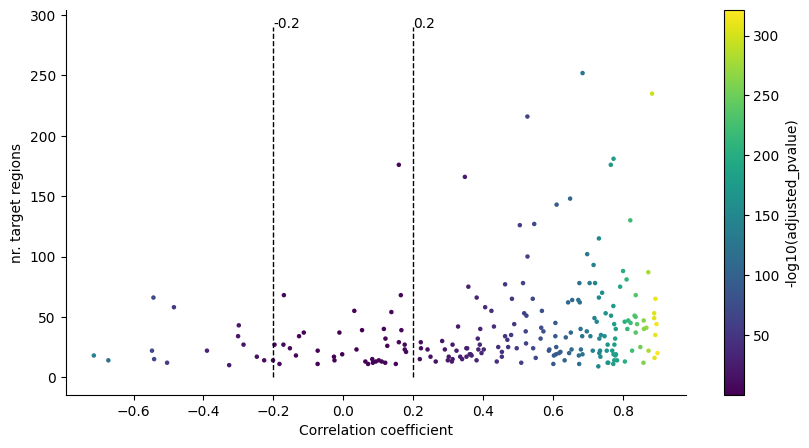

In [20]:
import numpy as np
n_targets = [int(x.split('(')[1].replace('r)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [-0.2, 0.2],
        'n_targets': 0
}
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target regions')
#ax.hlines(y = thresholds['n_targets'], xmin = min(rho), xmax = max(rho), color = 'black', ls = 'dashed', lw = 1)
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)
plt.show()

In [21]:
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 193 eRegulons


In [24]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']

,TF,Cistrome,Rho,P-value,Adjusted_p-value
0,rcor1,rcor1_+_(23r),0.283316,1.378541e-23,1.601733e-23
1,pou3f1,pou3f1_extended_+_(37r),0.859483,0.000000e+00,0.000000e+00
2,runx3,runx3_+_(44r),0.803490,4.042847e-272,1.700784e-271
3,tead1b,tead1b_+_(18r),0.313147,1.034653e-28,1.237527e-28
4,egr1,egr1_+_(12r),0.301310,1.319923e-26,1.563404e-26
...,...,...,...,...,...
117,mafbb,mafbb_+_(26r),0.566894,5.713063e-103,1.010136e-102
118,junbb,junbb_-_(18r),0.313719,8.137413e-29,9.829350e-29
119,dmbx1a,dmbx1a_+_(18r),0.713234,4.212087e-187,1.167897e-186
120,hnf1ba,hnf1ba_+_(33r),0.911092,0.000000e+00,0.000000e+00


In [25]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_gene_based']

,TF,Cistrome,Rho,P-value,Adjusted_p-value
0,rcor1,rcor1_+_(18g),0.526943,1.054694e-86,1.273987e-86
1,pou3f1,pou3f1_extended_+_(27g),0.791629,1.389624e-258,3.390683e-258
2,runx3,runx3_+_(25g),0.743778,8.047013e-212,1.663959e-211
3,tead1b,tead1b_+_(12g),0.696760,4.486860e-175,7.709816e-175
4,egr1,egr1_+_(10g),0.764870,4.713677e-231,1.045579e-230
...,...,...,...,...,...
117,mafbb,mafbb_+_(23g),0.805799,7.303124e-275,2.121384e-274
118,junbb,junbb_-_(15g),-0.714101,9.278206e-188,1.768658e-187
119,dmbx1a,dmbx1a_+_(14g),0.616465,1.594705e-126,2.186001e-126
120,hnf1ba,hnf1ba_+_(20g),0.950872,0.000000e+00,0.000000e+00


In [26]:
scplus_obj.uns['TF_cistrome_correlation']

{'filtered_gene_based':          TF                 Cistrome       Rho        P-value  \
 0     rcor1            rcor1_+_(18g)  0.526943   1.054694e-86   
 1    pou3f1  pou3f1_extended_+_(27g)  0.791629  1.389624e-258   
 2     runx3            runx3_+_(25g)  0.743778  8.047013e-212   
 3    tead1b           tead1b_+_(12g)  0.696760  4.486860e-175   
 4      egr1             egr1_+_(10g)  0.764870  4.713677e-231   
 ..      ...                      ...       ...            ...   
 117   mafbb            mafbb_+_(23g)  0.805799  7.303124e-275   
 118   junbb            junbb_-_(15g) -0.714101  9.278206e-188   
 119  dmbx1a           dmbx1a_+_(14g)  0.616465  1.594705e-126   
 120  hnf1ba           hnf1ba_+_(20g)  0.950872   0.000000e+00   
 121   hic1l            hic1l_+_(12g)  0.395700   2.912003e-46   
 
      Adjusted_p-value  
 0        1.273987e-86  
 1       3.390683e-258  
 2       1.663959e-211  
 3       7.709816e-175  
 4       1.045579e-230  
 ..                ...  
 117    

In [47]:
#dotplot

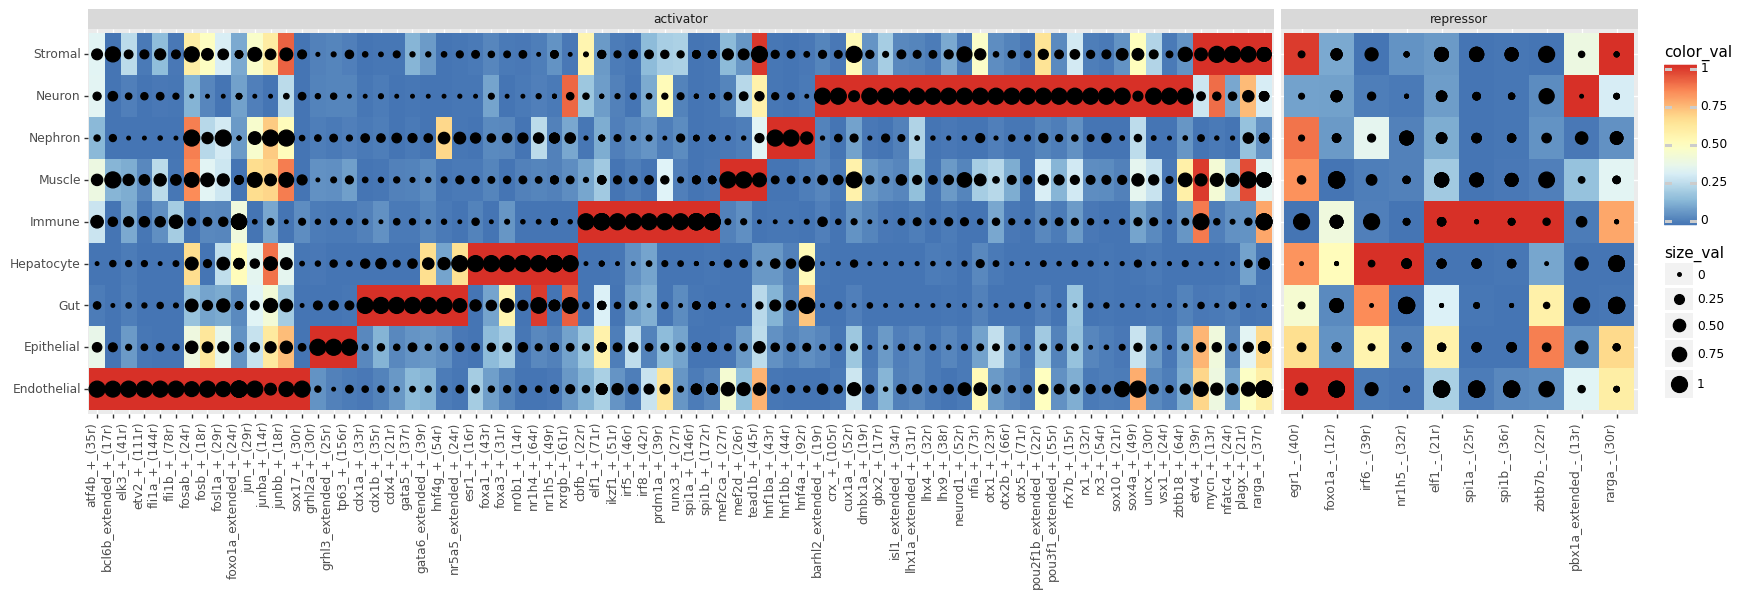

<ggplot: (8735320621894)>

In [21]:
from scenicplus.plotting.dotplot import heatmap_dotplot
import matplotlib.pyplot as plt
heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'], #specify what to plot as dot sizes, target region enrichment in this case
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'lineage',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
        #index_order = ['Astrocytes', 'Oligodendrocytes', 'Microglia', 'Cajal-Retzius cells', 'Purkinje neurons', 'Endothelial cells'], # check here
        figsize = (20, 5),
        orientation = 'horizontal')

In [22]:
use_tf=scplus_obj.uns['selected_eRegulon']['Gene_based']
use_tf=pd.DataFrame(use_tf,index=None)
use_tf.to_csv('./zebrafish_regulon.csv')

In [23]:
from scenicplus.plotting.dotplot import generate_dotplot_df
plotting_df = generate_dotplot_df(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'],
        color_matrix = scplus_obj.to_df('EXP'),
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'lineage',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'])
tmp = plotting_df[['index', 'eRegulon_name', 'color_val']
        ].pivot_table(index = 'index', columns = 'eRegulon_name'
        ).fillna(0)['color_val']
tmp
idx_max = tmp.idxmax(axis = 0)
order = pd.concat([idx_max[idx_max == x] for x in tmp.index.tolist() if len(plotting_df[plotting_df == x]) > 0]).index.tolist()
plotting_df['eRegulon_name'] = pd.Categorical(plotting_df['eRegulon_name'], categories = order)
plotting_df['repressor_activator'] = ['activator' if '+' in n.split('_')[1] and 'extended' not in n or '+' in n.split('_')[2] and 'extended' in n  else 'repressor' for n in plotting_df['eRegulon_name']]
plotting_df.to_csv('./zebrafish_tfdf_pseudo_20_total.csv')

In [24]:
import dill
dill.dump(scplus_obj, open(os.path.join(saveDir, 'scplus_obj_total.pkl'), 'wb'), protocol=-1)